# Dissolved Iron Datasets for Validation
## GEOTRACES & ML dFe Data

Note:
 - Requires storage gdata/e14+gdata/ua8+gdata/cj50

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import cmocean.cm as cmocean
import glob
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# change to your own directory on /g/data/:
figdir = Path('/g/data/e14/as3189/stellema/ACCESS-WOMBAT_01deg_BGC_validation/figs/')

# Datasets

## GEOTRACES Data

<details>
    <summary>Data variable details:</summary>
    
    metavar1	Cruise
    metavar2	Station
    metavar3	Type
    longitude	Longitude	degrees_east
    latitude	Latitude	degrees_north
    metavar4	Bot. Depth	m	Bottom depth
    metavar5	Operator's Cruise Name
    metavar6	Ship Name
    metavar7	Period
    metavar8	Chief Scientist
    metavar9	GEOTRACES Scientist
    metavar10	Cruise Aliases
    metavar11	Cruise Information Link
    metavar12	BODC Cruise Number
    date_time	Decimal Gregorian Days of the station	days since 2006-01-01 00:00:00 UTC	Relative Gregorian Days with decimal part
    var1	CTDPRS_T_VALUE_SENSOR	dbar	Pressure from CTD sensor
    var2	DEPTH	m	Depth below sea surface calculated from pressure
    var3	Rosette Bottle Number		Bottle number on the rosette
    var4	GEOTRACES Sample ID		GEOTRACES sample id
    var5	Bottle Flag		Quality flag for the entire bottle
    var6	Cast Identifier		Cast identifier as string
    var7	Sampling Device		Sampling device descriptor
    var8	BODC Bottle Number		Unique BODC bottle number
    var9	BODC Event Number		Unique BODC event number
    var88	Fe_D_CONC_BOTTLE	nmol/kg	Concentration of dissolved Fe
    var89	Fe_II_D_CONC_BOTTLE	nmol/kg	Concentration of dissolved Fe(II)
    var90	Fe_S_CONC_BOTTLE	nmol/kg	Concentration of operationally defined soluble Fe
</details>

In [2]:
def Fe_obs_GEOTRACES(var='var88', lats=[-10, 10], lons=[130, 285]):
    """Open geotraces data, subset location and convert to multi-dim dataset."""
    # @todo: drop bad data np.unique(ds.var5)
    # @todo: bin model depths?
    file = '/g/data/ua8/GEOTRACES/idp2021/GEOTRACES_IDP2021_v1/seawater/netcdf/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'
    ds = xr.open_dataset(file)

    ds = ds.rename({'date_time': 'time', 'var2': 'depth'})
    ds['time'] = ds.time.astype(dtype='datetime64[D]')  # Remove H,M,S values from time.

    # Drop extra data variables.
    keep_vars = ['time', 'depth', 'latitude', 'longitude', var]
    ds = ds.drop([v for v in ds.data_vars if v not in keep_vars])
    
    # Subset lat/lons.
    ds = ds.where((ds.latitude >= lats[0]) & (ds.latitude <= lats[1]), drop=True)
    ds = ds.where((ds.longitude >= lons[0]) & (ds.longitude <= lons[1]), drop=True)
    
    # Drop coords where var is all NaN.
    ds = ds.dropna('N_SAMPLES', how='all')
    ds = ds.sel(N_SAMPLES=ds[var].dropna('N_SAMPLES', 'all').N_SAMPLES)
    
    # Convert to multi-dim array.
    ds = ds.stack({'index': ('N_STATIONS', 'N_SAMPLES')})
    ds = ds.drop_vars(['N_SAMPLES', 'N_STATIONS'])
    index = pd.MultiIndex.from_arrays([ds.time.values, ds.depth.values, 
                                       ds.latitude.values, ds.longitude.values], 
                                      names=['t', 'z', 'y', 'x'],)
    ds = ds.assign_coords({'index': index})
    ds = ds.dropna('index', how='all')
    ds = ds.unstack('index')
    ds = ds.drop(['time', 'depth', 'latitude', 'longitude'])

    # Add data var attrs.
    for v, n, u in zip(['y', 'x', 'z'], ['Latitude', 'Longitude', 'Depth'], ['°', '°', 'm']):
        # ds = ds.sortby(ds[v])  # very slow - only needed if new coordinates are out of order.
        ds = ds.dropna(v, 'all')
        ds[v].attrs['long_name'] = n
        ds[v].attrs['standard_name'] = n.lower()
        ds[v].attrs['units'] = u
    return ds

In [ ]:
# @ TODO

def Fe_obs_GEOTRACES_sel_cruise(var='var88', cruise='GP19'):
    """Open geotraces data and subset by cruise."""
    file = '/g/data/ua8/GEOTRACES/idp2021/GEOTRACES_IDP2021_v1/seawater/netcdf/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'
    ds = xr.open_dataset(file)
    ds = ds.rename({'date_time': 'time', 'var2': 'depth'})
    ds['time'] = ds.time.astype(dtype='datetime64[D]')  # Remove H,M,S values from time.

    # Drop extra data variables.
    keep_vars = ['time', 'depth', 'latitude', 'longitude', var]
    ds = ds.drop([v for v in ds.data_vars if v not in keep_vars])
    
    # Extract individual data arrays since you can't subset datasets using index locations
    cruise = np.full(len(ds.metavar1), 'sssssss')
    for i in range(len(cruise)):
        cruise[i] = str(ds.metavar1[i].data)[2:-1]  
    #station = np.full(len(ds.station), 'sssssss')
    #for i in range(len(station)):
    #    station[i] = str(ds.station[i].data)[2:-1]  
    lon = ds.longitude
    lat = ds.latitude
    
    # subset for specific cruise
    cruiseidx = np.where(cruise==cruiseID)[0]
    cruise = cruise[cruiseidx]
    lon = lon[cruiseidx]
    lat = lat[cruiseidx]
    
    if (cruise == 'GP19').all():
        # one bad point in this cruise - it's not on the transect
        lon = lon[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,]]
        lat = lat[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,]]

    # now use these lat and lon values to subset the original GEOTRACES dataset
    ds = ds = ds.where(ds.longitude.isin(lon),drop=True)
    ds = ds.where(ds.latitude.isin(lat),drop=True)
    
    return ds

# var='var88'
# cruise='GP19'
# file = '/g/data/ua8/GEOTRACES/idp2021/GEOTRACES_IDP2021_v1/seawater/netcdf/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'
# ds = xr.open_dataset(file)
# ds = ds.rename({'date_time': 'time', 'var2': 'depth', 'metavar1': 'cruise'})
# ds['time'] = ds.time.astype(dtype='datetime64[D]')  # Remove H,M,S values from time.

# # Drop extra data variables.
# keep_vars = ['time', 'depth', 'latitude', 'longitude', 'cruise', var]
# ds = ds.drop([v for v in ds.data_vars if v not in keep_vars])

## Huang et al. (2022) ML compilation

In [3]:
def dFe_obs_ML():
    """Huang et al. (2022)
    dFe climatology based on compilation of dFe observations + environmental predictors
    from satellite observations and reanalysis products using machine-learning approaches
    (random forest).

    """
    file = '/g/data/e14/as3189/obs/Huang_et_al_2022_monthly_dFe_V2.nc'
    ds = xr.open_dataset(file)
    ds = ds.rename({'Longitude': 'x', 'Latitude': 'y', 'Depth': 'z', 'Month': 't'})
    ds.coords['x'] = xr.where(ds.x < 0, ds.x + 360, ds.x, keep_attrs=True)
    ds = ds.sortby(ds.x)
    for v, n, u in zip(['y', 'x', 'z'], ['Latitude', 'Longitude', 'Depth'], ['°', '°', 'm']):
        ds = ds.sortby(ds[v])
        ds[v].attrs['long_name'] = n
        ds[v].attrs['standard_name'] = n.lower()
        ds[v].attrs['units'] = u
    return ds.dFe_RF

### Function to create cartopy map for plots

In [4]:
def create_map_axis(fig, ax, extent=[120, 285, -10, 10]):
    """Create a figure and axis with cartopy."""
    projection = ccrs.PlateCarree(central_longitude=180)
    proj = ccrs.PlateCarree()
    proj._threshold /= 20.

    # Set map extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent(extent, crs=proj)

    # Features.
    ax.add_feature(cfeature.LAND, color=cfeature.COLORS['land_alt1'])
    ax.add_feature(cfeature.COASTLINE)

    # Set ticks.
    xticks = np.arange(*extent[:2], 20)
    ax.set_xticks(xticks, crs=proj)
    ax.set_xticklabels(['{}°E'.format(i) for i in xticks])
    ax.set_yticks(ax.get_yticks(), crs=proj)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    # # Minor ticks.
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    fig.subplots_adjust(bottom=0.2, top=0.8)
    ax.set_aspect('auto')
    return fig, ax, proj

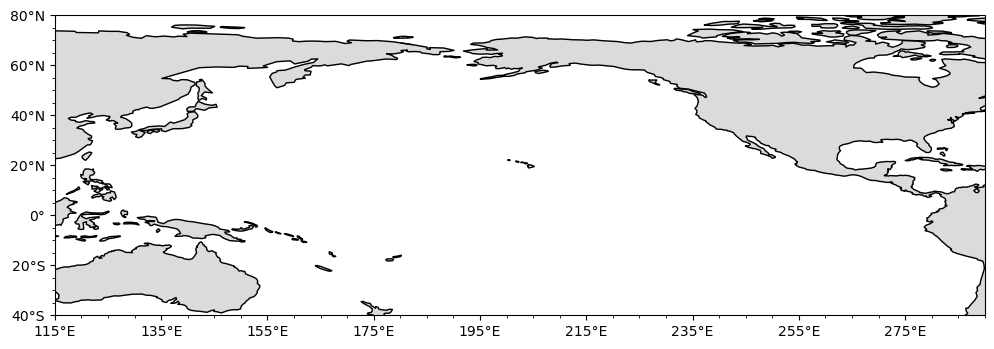

In [5]:
# for example
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
# ax = [fig.add_subplot(211 + i, projection=ccrs.PlateCarree(central_longitude=180)) for i in [0, 1]]
fig, ax, proj = create_map_axis(fig, ax, extent=[115, 290, -40, 70])

# GEOTRACES dFe data plots

In [12]:
# Open GEOTRACES dFe data subset (N.B. very slow/fails for large area subsets).
var = 'var88'
lats = [-9, 9]
lons = [140, 285]
ds = Fe_obs_GEOTRACES(var, lats, lons)
ds = ds[var]

In [13]:
# dx = ds.sel(x=slice(147.7,  155), y=slice(-9.25, -3))
# dx = dx.where(~np.isnan(dx), drop=True)
# dx.mean('t').plot(col='z', col_wrap=5)

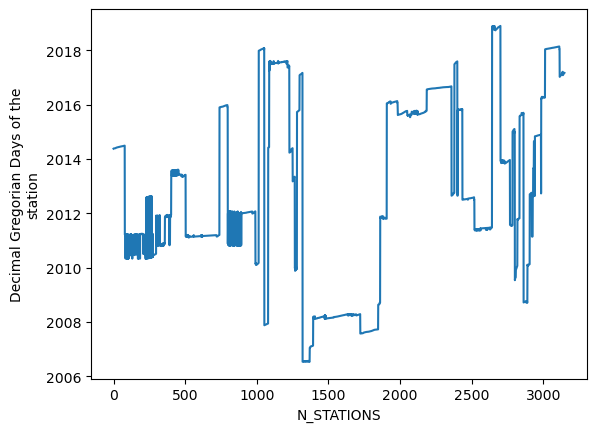

In [14]:
file = '/g/data/ua8/GEOTRACES/idp2021/GEOTRACES_IDP2021_v1/seawater/netcdf/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'
df = xr.open_dataset(file)
df.date_time.plot()

# Plot: all x-y locations.

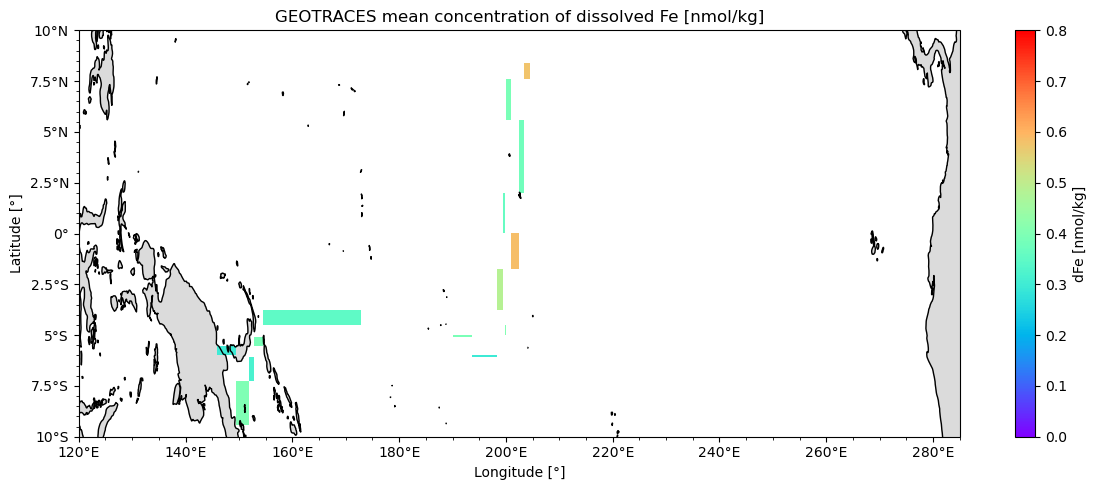

In [15]:
# Plot: all x-y locations.
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
fig, ax, proj = create_map_axis(fig, ax)
cs = ds.mean(['t', 'z'], skipna=True).plot(ax=ax, vmin=0, vmax=0.8, cmap=plt.cm.rainbow, transform=proj)
ax.set_title('GEOTRACES mean concentration of dissolved Fe [nmol/kg]')
cbar = cs.colorbar
cbar.set_label('dFe [nmol/kg]')
plt.tight_layout()
plt.savefig(figdir / 'GEOTRACES_dFe_map.png')
plt.show()

# Huang et al. (2022) dFe data plots

In [16]:
dx = dFe_obs_ML()
dx = dx.isel(t=-1)  # Annual.

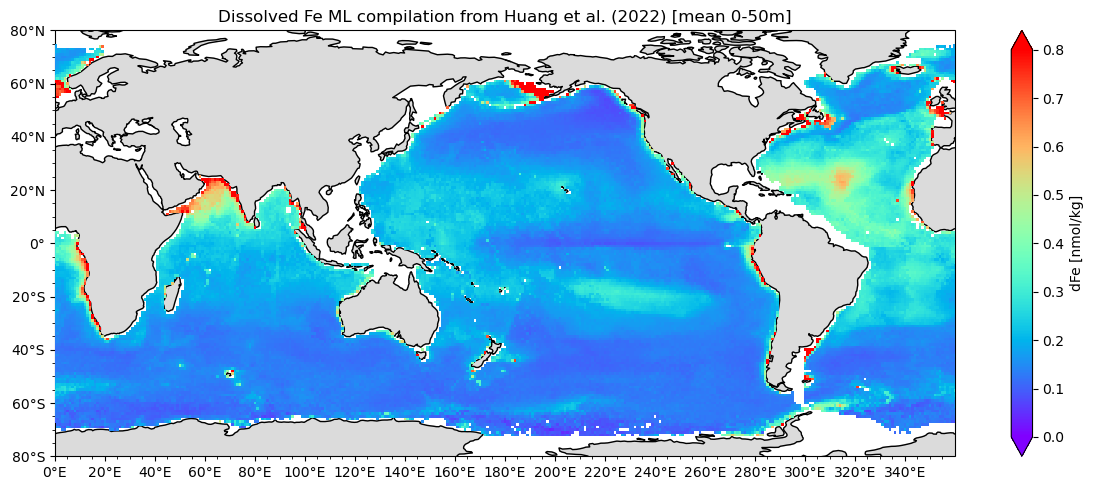

In [19]:
# Plot: all x-y locations.
z = [0, 50] # Depth slice
dxx = dx.sel(z=slice(*z)).mean('z')

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
fig, ax, proj = create_map_axis(fig, ax, extent=[0, 360, -80, 80])

cs = dxx.plot(ax=ax, zorder=5, cmap=plt.cm.rainbow, vmin=0, vmax=0.8, extend='both', transform=proj)
ax.set_title('Dissolved Fe ML compilation from Huang et al. (2022) [mean {}-{}m]'.format(*z))
ax.set_xlabel('')
ax.set_ylabel('')
cbar = cs.colorbar
cbar.set_label('dFe [nmol/kg]')
plt.tight_layout()
plt.savefig(figdir / 'dFe_obs_ML_map_{}-{}m.png'.format(*z))
plt.show()

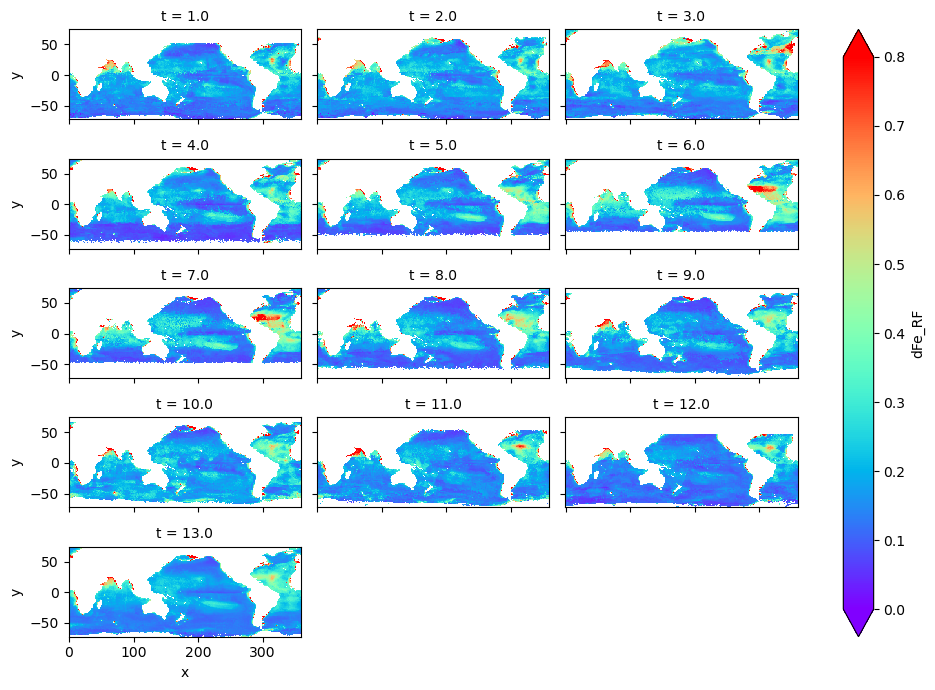

In [18]:
# Plot: all x-y locations (for each month).
z = [0, 50] # Depth slice
dxx = dFe_obs_ML()
dxx = dxx.sel(z=slice(*z)).mean('z')
cs = dxx.plot(figsize=(10, 7), col='t', col_wrap=3, cmap=plt.cm.rainbow, vmin=0, vmax=0.8, extend='both')

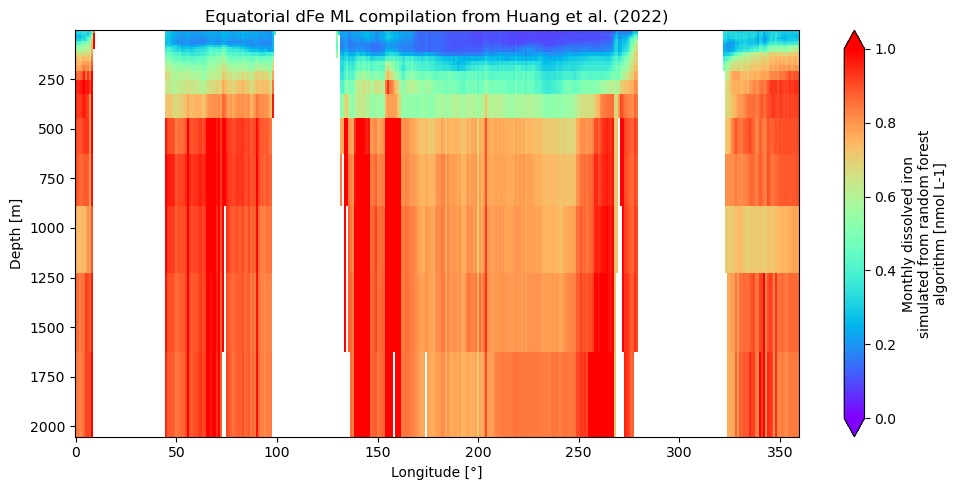

In [20]:
# Plot: equatorial depth profile.
fig, ax = plt.subplots(figsize=(10, 5))
dxx = dx.sel(y=0, z=slice(0, 2000))
cs = dxx.plot(yincrease=False, cmap=plt.cm.rainbow, vmin=0, vmax=1, extend='both')
ax.set_title('Equatorial dFe ML compilation from Huang et al. (2022)')
plt.tight_layout()
plt.savefig(figdir / 'dFe_obs_ML_eq.png')
plt.show()

# ACCESS Climatatology

In [ ]:
client = Client()

In [ ]:
master_session = cc.database.create_session()
control = '01deg_jra55v140_iaf_cycle4'
start_time = '2008-01-01'
end_time = '2019-12-31'

In [ ]:
# Filename to save dataset.
# file = Path('/g/data/e14/as3189/stellema/ACCESS-WOMBAT_01deg_BGC_validation/access_fe_{}-{}_clim_global.nc'.format(start_time[:4], end_time[:4]))
file = Path('/g/data/e14/as3189/stellema/ACCESS-WOMBAT_01deg_BGC_validation/access_fe_{}-{}_clim.nc'.format(start_time[:4], end_time[:4]))

In [ ]:
ds = cc.querying.getvar(control, 'fe', master_session, ncfile='oceanbgc-3d%monthly%', start_time=start_time, end_time=end_time)

# Subset data:
ds = ds.sel(time=slice(start_time, end_time))
ds = ds.sel(yt_ocean=slice(-30, 30))  # Not global

Compute climatology:
ds = ds.groupby('time.month').mean('time', keep_attrs=True)
ds = ds.rename({'month': 'time'})

# Save clim dataset:
ds = ds.chunk('auto')
ds.to_netcdf(file, compute=True)

# ACCESS & OBS Plots

In [21]:
# ACCESS clim dataset
file = Path('/g/data/e14/as3189/stellema/ACCESS-WOMBAT_01deg_BGC_validation/access_fe_2008-2019_clim.nc')
ds = xr.open_dataset(file)
ds = ds.rename({'time': 't', 'st_ocean': 'z', 'yt_ocean': 'y', 'xt_ocean': 'x'})
ds = ds.fe

In [22]:
# ML dataset
dx = dFe_obs_ML()
dx = dx.sel(y=slice(-30, 30))

In [23]:
# Annual means
ds = ds.mean('t', keep_attrs=True)  # slow.
dx = dx.isel(t=-1)
# ACCESS fe [umol/m^3] = ML fe [nmol L-1]

## Plot depth-averaged map for ACCESS and Huang et al. (2022) data.

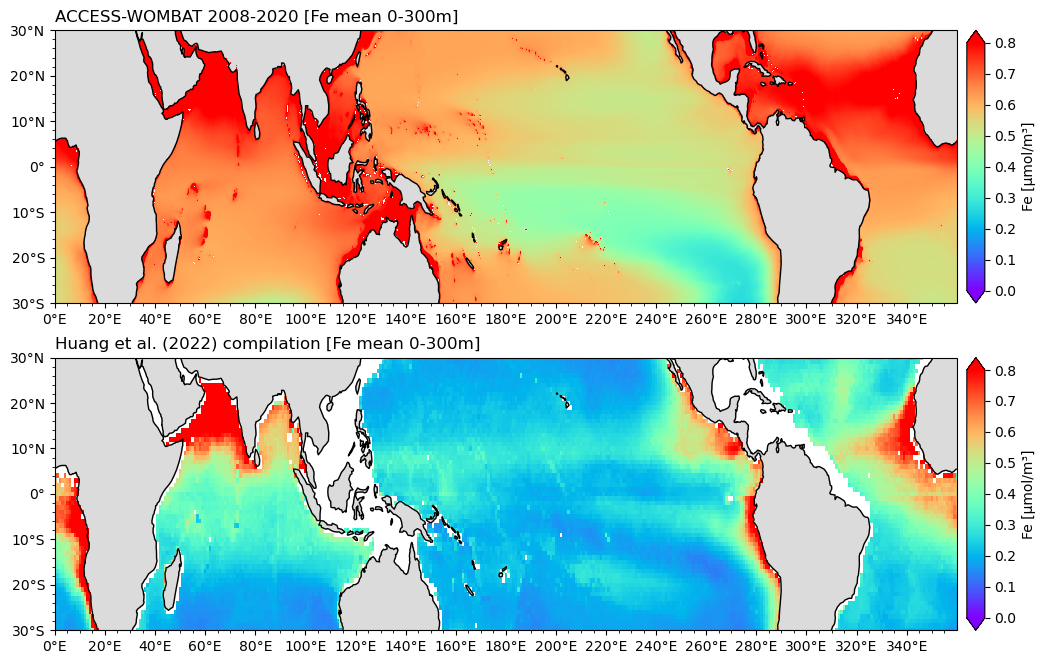

In [24]:
z = [0, 300]  # Depth slice.

fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(211 + i, projection=ccrs.PlateCarree(central_longitude=180)) for i in [0, 1]]

names = ['ACCESS-WOMBAT 2008-2020', 'Huang et al. (2022) compilation']
for i, da in enumerate([ds, dx]):
    da = da.sel(z=slice(*z)).mean('z')
                
    fig, ax[i], proj = create_map_axis(fig, ax[i], extent=[0, 360, -30, 30])
    cs = ax[i].pcolormesh(da.x, da.y, da, vmax=0.8, vmin=0, cmap=plt.cm.rainbow, transform=proj)
    
    ax[i].set_title('{} [Fe mean {}-{}m]'.format(names[i], *z), loc='left')
    
    # Add colourbar to RHS of each subplot.
    div = make_axes_locatable(ax[i])
    cax = div.append_axes('right', size='2%', pad=0.1, axes_class=plt.Axes)
    cbar = fig.colorbar(cs, cax=cax, orientation='vertical', extend='both')
    cbar.set_label('Fe [µmol/m³]')
plt.savefig(figdir / 'dFe_map_ACCESS_ML_30S-30N_{}-{}m.png'.format(*z))
plt.show()